# Lab Assignment One: Exploring Table Data

### Authors
- Juliana Antonio
- Xiaona Hang
- Chuanqi Deng


### 1. Business Understanding 

This data is intended to be used as a predictive tool whether a patient is likely to have a stroke based on certain medical features. It can also be used to detect trends in which features contribute to whether a person has a stroke or not. 

According to the Center for Disease Control and Prevention (CDC) (https://www.cdc.gov/stroke/facts.htm), more than 795,000 people in the United States have a stroke with 610,000 being first time strokes. Not only does this impact the lives of a variety of populations, but it also creates a huge impact on the cost of the American Healthcare system, with stroke-related costs being about 56.5 billion dollars in 2018 and 2019. 

There are many factors/risks associated with having a stroke, as indicated by https://www.strokeinfo.org/stroke-risk-factors/, such as high blood pressure, obesity (which can be measured with body mass index - BMI), family history, high cholesterol, and an age above 65. Lifestyle habits such as smoking and poor diet can also increase this risk. Typically, it is recommended to visit a medical professional when a person has multiple risk factors for a stroke. There is an abundance of data that is obtained from electronic health care records, most of which are features which are usually not relevant or useful. Machine Learning could play a beneficial role in facilitating predicitive tools that could measure the risk of having a stroke with the most important features (in this dataset there are 11 features with 5110 occurances). This offers a cheaper alternative and would be of interest to the medical professionals, specifically to primary care physicians (PCP) who deal with the routine care of patients from all ages and backgrounds.

As such, the aims of exploring this dataset would be to detect which features have the highest risk associated with having a stroke. The data was collected from Kaggle, however, after extensive research on where the meta-data came from, it can only be assumed that it was collected and trunacted from the electronic health records from McKinsey & Company (we believe it came from this paper specifically: https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9264165).

### Measures of Success

Dealing with measures of success when it comes to the medical field can be difficult and varies based on whether you have balanced or imbalanced data. In this scenario, doctors and patients would like a high success rate. In the case of imbalanced data, it is often taken care of through sensitivity or recall (true positive rate), where the number of true positives (people who had a stroke and were predicted to have a stroke) is divided by the number of true positives plus the number of false negatives (people who had a stroke but were classified as not having a stroke). From https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8686476/ "It is the likelihood that the patient has a high risk of stroke is correctly predicted." Combined with recall, precision is the number of true positives divided by the number of true positives plus the number of false positives (those who did not have a stroke but were predicted to). It essentially indicates how many of those who had a stroke actually belong to that class. Lastly, another measure of success, regardless of balanced or imbalanced data, is through specificity (true negative rate), which measures the proportion of individuals who are classified to not have a stroke to the total number of actual nonstroke cases, i.e. the probability that a patient who does not have a high risk of stroke will have a negative result. 

All of these techniques can be used to measure the successful outcomes of ML models with a particular dataset. The overarching goal would be to have true positives and true negatives, rather than false negatives and false positives, to mitigate unecessary medical costs. 

Dataset source: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?resource=download 

In [49]:
import time
import warnings

import matplotlib.pyplot as plt
# Use the 'missingno' package which is an external package to detect any missing values
import missingno as mn
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as piopio
import seaborn as sns
import umap
import umap.plot
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

ModuleNotFoundError: No module named 'missingno'

In [ ]:
piopio.renderers.default='notebook'
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline 

# load the stroke dataset

df = pd.read_csv('data/healthcare-dataset-stroke-data.csv')
df.drop(columns = ["id"], inplace = True)
df.head() 

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
#info about dataset types
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [ ]:
#Continious Data and categorical data
attribute_cols = list(df.columns)
categorical_cols = [column for column in attribute_cols if len(df[column].unique())<=5]
continous_cols = [column for column in attribute_cols if column not in categorical_cols]

print(f"Continous Data Columns: {','.join(continous_cols)}")
print(f"Categorical Data Columns: {','.join(categorical_cols)}")

Continous Data Columns: age,avg_glucose_level,bmi
Categorical Data Columns: gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke


### 2. Data Preparation
#### 2.1. Read Images

In [51]:
from collections import defaultdict
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.decomposition import PCA

In [50]:
images = defaultdict(list)
labels = defaultdict(list)
uniformed_size = (224,224)

for image_path in Path('data').rglob('*.jpg'):
    class_name = image_path.parent.stem
    train_test = image_path.parent.parent.stem
    img = cv2.resize(cv2.imread(str(image_path)),uniformed_size)
    images[train_test].append(img)
    labels[train_test].append(class_name)


train_imgs = np.concatenate([images['train']])
test_imgs = np.concatenate([images['test']])

print(f"Train: {train_imgs.shape}, Test: {test_imgs.shape}")

Train: (3352, 224, 224, 3), Test: (813, 224, 224, 3)


#### 2.2. Linearize

In [53]:
train_imgs = train_imgs.reshape((len(train_imgs), -1))
test_imgs = test_imgs.reshape((len(test_imgs), -1))
print(f"Train: {train_imgs.shape}, Test: {test_imgs.shape}")

Train: (3352, 150528), Test: (813, 150528)


#### 2.3. Visualization

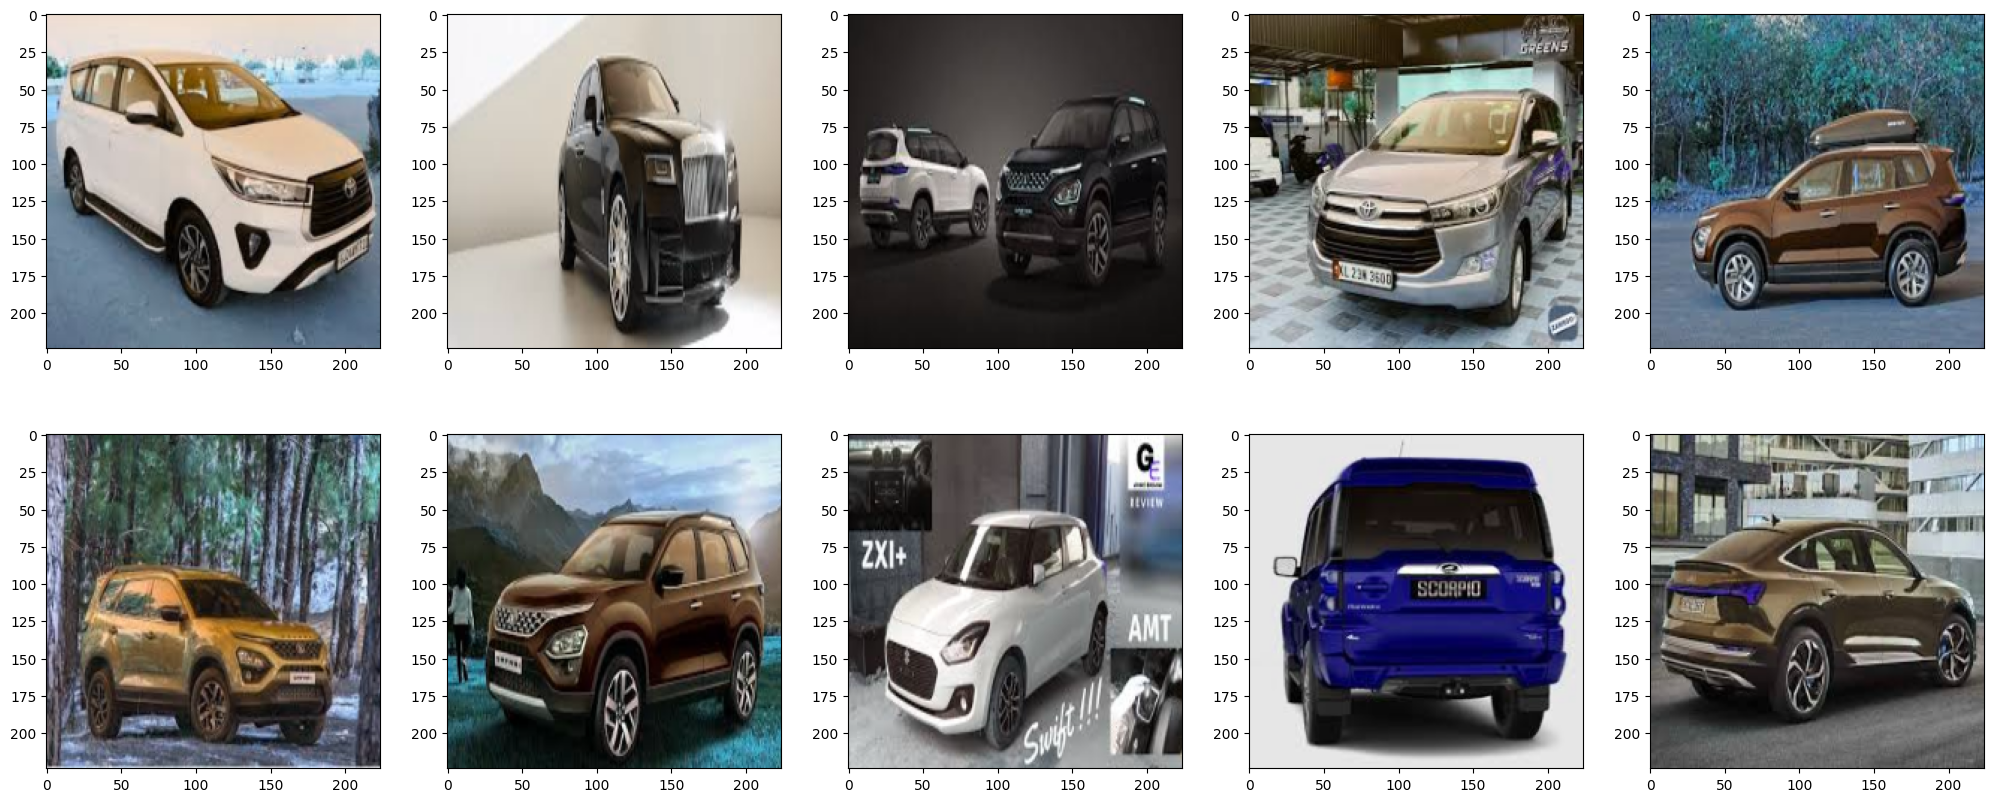

In [ ]:

plt.figure(figsize=(25,10))
for i, r_idx in enumerate(np.random.randint(0, len(images['train']), 10)):
    ax = plt.subplot(2,5,i+1)
    ax.imshow(images['train'][r_idx])

### 3. Data Reduction

### 3.1 PCA

In [95]:
n_components = 150
required_component_ratio = 0.8
pca = PCA(n_components)
data_pca = pca.fit_transform(train_imgs)

Text(0.5, 1.0, 'Percentage of variance explained by each components')

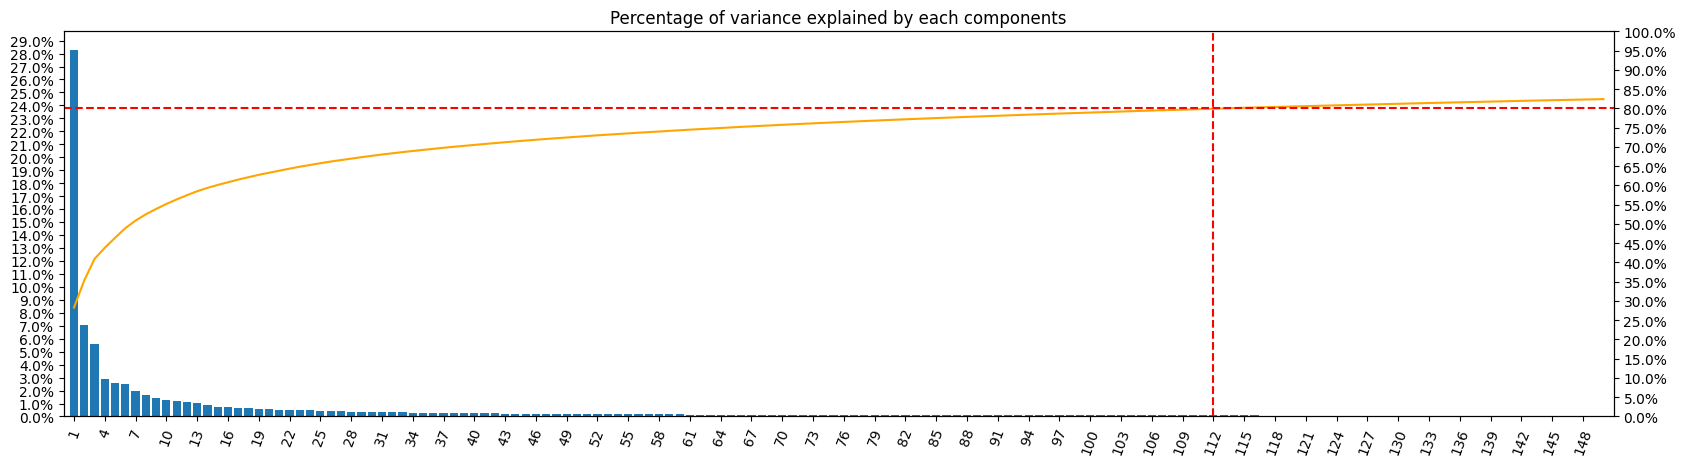

In [105]:
accumulated_ratio = np.cumsum(pca.explained_variance_ratio_)
ratio_idx = np.argmax(accumulated_ratio >= required_component_ratio)

# ploting
plt.figure(figsize=(20,5))
plt.bar(range(1, n_components+1), pca.explained_variance_ratio_)
plt.xticks(range(1, n_components+1, 3), rotation=70)
plt.yticks(np.arange(0, 0.30, 0.01), [f"{x*100:.1f}%" for x in np.arange(0, 0.30, 0.01)])
plt.xlim(0, n_components+1)

ax = plt.twinx()
ax.set_yticks(np.arange(0, 1.01, 0.05), [f"{x*100:.1f}%" for x in np.arange(0, 1.01, 0.05)])
ax.set_ylim(0,1)
ax.plot(range(1, n_components+1), accumulated_ratio, color='orange')
ax.axvline(x=ratio_idx, color='red', linestyle='--')
ax.axhline(y=required_component_ratio, color='red', linestyle='--')

plt.title("Percentage of variance explained by each components")

As evident above, we are experiencing a highly imbalanced dataset (95.1% of the data has no stroke, while only 4.87% have stroke), which would have to be dealt with in prediction models, either with upscaling or oversampling. 

Let's look at the distribution of the continuous data: bmi, avg_glucose_level, and age. 

### 4. Exceptional Work
#### 4.1 Overall Quality
The report is coherent, useful. and polished product. It make sense overall. The visualizations answered the questions in the Business Understanding. The sources are properly cited in the Reference section. Specific reasons for the assumptions are provided. Subsequent questions are followed naturally from initial exploration.
#### 4.2 Additional analysis

UMAP is one of dimension deduction methods. Compare to other techniques such as t-SNE, UMAP offers a number of advantages. Firstly, it's fast. On MINST dataset, UMAP can project the data less than 3 minutes, while t-SNE can take up to 45 minutes. Secondly, UMAP better preserve global structure of the data. This due to UMAP's strong theoretical foundations. Lastly, UMAP offers more understandable parameters that make it a more effective tool for visualizing high dimensional data.

UMAP starts by constructing a graph that captures relationships between data points. It then optimizes a low-dimensional representation that preserves these relationships, ensuring that nearby points in the high-dimensional space remain close in the reduced space. UMAP strikes a balance between preserving local structure, representing fine details, and maintaining global structure, capturing broader patterns.

Text(0.5, 0.92, 'Supervised UMAP Projection of the Stroke Data')

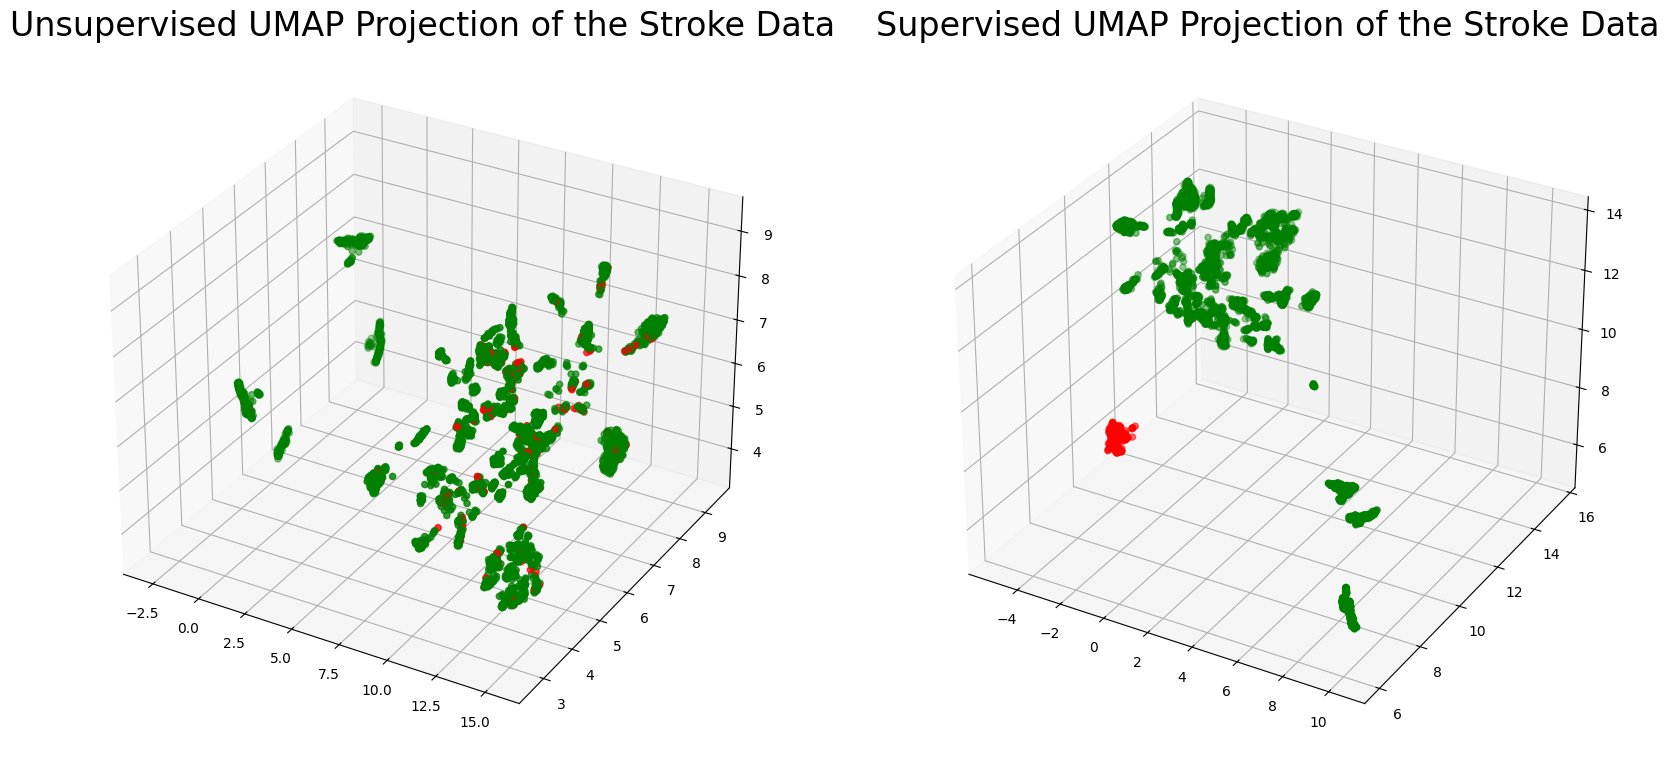

In [32]:
# UMAP dimension deduction
data_umap_unsupervised = umap.UMAP(n_components=3, n_neighbors=500).fit_transform(data_scaled)
data_umap_supervised = umap.UMAP(n_components=3, n_neighbors=500).fit_transform(data_scaled,  y = labels)

# plot the results
plot_colors = labels.map(lambda x: 'red' if x == 1 else 'green')

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(
    data_umap_unsupervised[:, 0],
    data_umap_unsupervised[:, 1],
    data_umap_unsupervised[:, 2],
    c=plot_colors)
plt.title('Unsupervised UMAP Projection of the Stroke Data', fontsize=24)

ax = fig.add_subplot(122, projection='3d')
ax.scatter(
    data_umap_supervised[:, 0],
    data_umap_supervised[:, 1],
    data_umap_supervised[:, 2],
    c=plot_colors)
plt.title('Supervised UMAP Projection of the Stroke Data', fontsize=24)

From the plots shown, the unsupervised UMAP failed to separate the dataset. In contrast, the supervised UMAP is able to separate the data into distinct clusters with data labels, despite that a small portion of stroke data is mixed with other data points.

References:

- Kaggle. Stroke Prediction Dataset. https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?resource=download (Accessed 2-04-2024)

- Center for Disease Control and Prevention. Stroke Facts. https://www.cdc.gov/stroke/facts.htm (Accessed 02-05-2024)

- Stroke Awareness Foundation. Stroke Risk Factors. https://www.strokeinfo.org/stroke-risk-factors/ (Accessed 02-05-2024)

- M.S. Pathan, et. al. "Identifying Stroke Indicators Using Rough Sets". https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9264165 (Accessed 02-05-2024)

- E.M. Alanazi, et. al. "Predicting Risk of Stroke From Lab Tests Using Machine Learning Algorithms: Development and Evaluation of Prediction Models" https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8686476/ (Accessed 02-05-2024)

- D. Zaric. Better Heatmaps and Correlation Matrix Plots in Python. https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec#:~:text=Let's%20start%20by%20making%20a,the%20larger%20the%20correlation%20magnitude. (Accessed 02-07-2024) 



